In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys

sys.path.insert(0, r'C:\Users\user\Scripts\TimeseriesFunctions')
from timeseries_functions import *

df = pd.read_csv(r'C:\Users\user\Scripts\Crypto\crypto_ohlcv-master\ETH-USD.csv')
df.index = df.date


In [2]:
df["date"] = pd.to_datetime(df["date"])
df.index = df.date

logic = {'open'  : 'first',
         'high'  : 'max',
         'low'   : 'min',
         'close' : 'last',
         'volume': 'sum',}

offset = pd.offsets.timedelta(days=-6)
df = df.resample('W', loffset=offset).apply(logic)
df['returns'] = (df['close'] - df['close'].shift())/df['close']
df['signal'] = df['returns'].abs()
df = df[1:]

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                returns   No. Observations:                  236
Model:               MarkovRegression   Log Likelihood                 108.317
Date:                Sun, 20 Sep 2020   AIC                           -204.634
Time:                        22:34:46   BIC                           -183.851
Sample:                    03-14-2016   HQIC                          -196.256
                         - 09-14-2020                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0170      0.011      1.494      0.135      -0.005       0.039
sigma2         0.0089      0.002      3.950      0.000       0.004       0.013
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0254      0.035     -0.725      0.468      -0.094       0.043
sigma2         0.0582      0.014      4.214      0.000       0.031       0.085
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.8415      0.085      9.908      0.000       0.675       1.008
p[1->0]        0.2710      0.192      1.412      0.158      -0.105       0.647
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

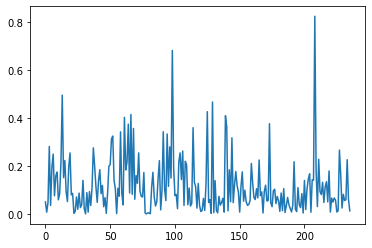

In [3]:
# Plot the data
plt.plot(df['signal'].values)
# from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutogregression

# # Fit the model
# # (a switching mean is the default of the MarkovRegession model)
mod_fedfunds = sm.tsa.MarkovRegression(df.returns, k_regimes=2, switching_variance=True)
res_fedfunds = mod_fedfunds.fit()
res_fedfunds.summary()

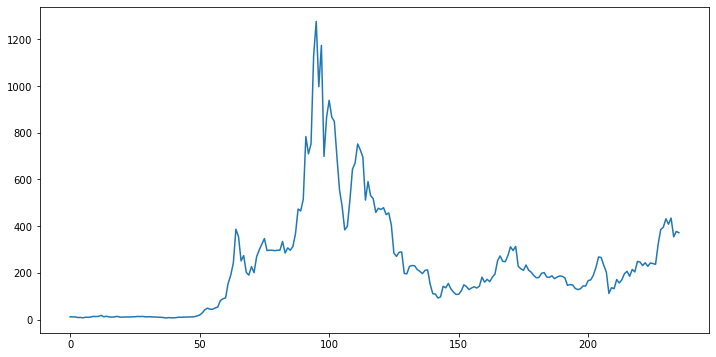

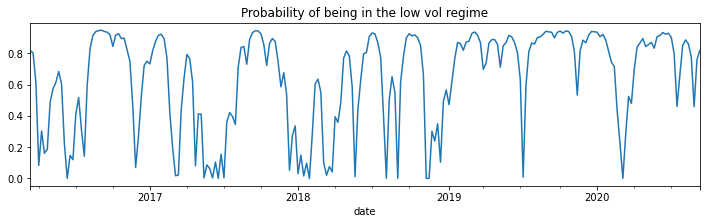

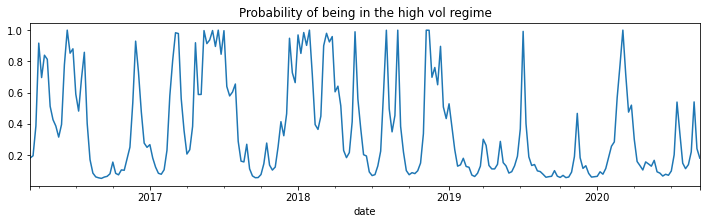

In [4]:
figure(figsize=(12,6))
plt.plot(df.close.values)

figure()
res_fedfunds.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in the low vol regime', figsize=(12,3));
figure()
res_fedfunds.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in the high vol regime', figsize=(12,3));

In [5]:
res_fedfunds.smoothed_marginal_probabilities
res_fedfunds.smoothed_marginal_probabilities['returns'] = df['returns']

mask_regime1 = (res_fedfunds.smoothed_marginal_probabilities[0] > .8)
mask_regime2 = (res_fedfunds.smoothed_marginal_probabilities[1] > .8)


regime1 = res_fedfunds.smoothed_marginal_probabilities.loc[mask_regime1]
regime2 = res_fedfunds.smoothed_marginal_probabilities.loc[mask_regime2]
print(regime1['returns'].mean(), regime1['returns'].std())
print(regime2['returns'].mean(), regime2['returns'].std())

0.012268296361265764 0.0711579445845282
-0.09316367646207405 0.33384445805385254


# Same model but we add an extra explanatory variable in the form of the previous lag value of target variable (prev timestep return)

In [6]:
# # Fit the model
# # (a switching mean is the default of the MarkovRegession model)
mod_fedfunds = sm.tsa.MarkovRegression(df.returns[1:], k_regimes=2, switching_variance=True, exog=df.signal[:-1])
res_fedfunds = mod_fedfunds.fit()
res_fedfunds.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                returns   No. Observations:                  235
Model:               MarkovRegression   Log Likelihood                 108.501
Date:                Sun, 20 Sep 2020   AIC                           -201.001
Time:                        22:34:47   BIC                           -173.325
Sample:                    03-21-2016   HQIC                          -189.843
                         - 09-14-2020                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0128      0.014      0.889      0.374      -0.015       0.041
x1             0.0910      0.121      0.753      0.451      -0.146       0.328
sigma2         0.0096      0.003      3.641      0.000       0.004       0.015
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0789      0.064     -1.241      0.214      -0.203       0.046
x1             0.2504      0.236      1.063      0.288      -0.211       0.712
sigma2         0.0604      0.016      3.764      0.000       0.029       0.092
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.8391      0.100      8.401      0.000       0.643       1.035
p[1->0]        0.3274      0.297      1.104      0.270      -0.254       0.908
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

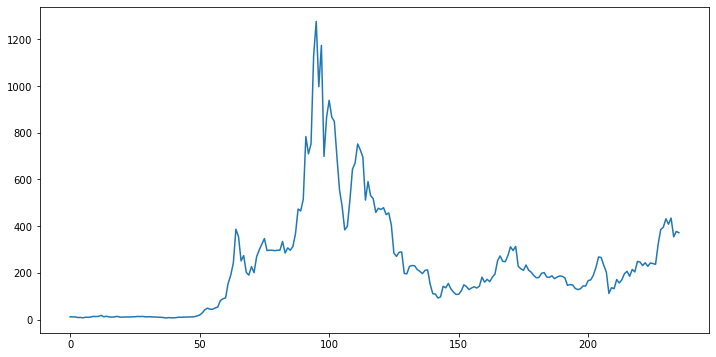

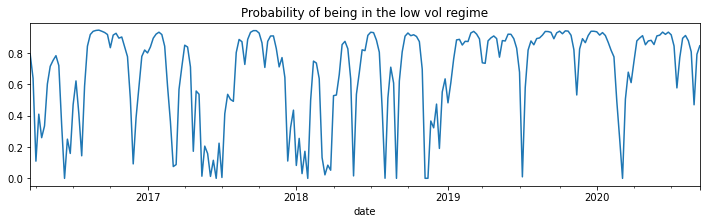

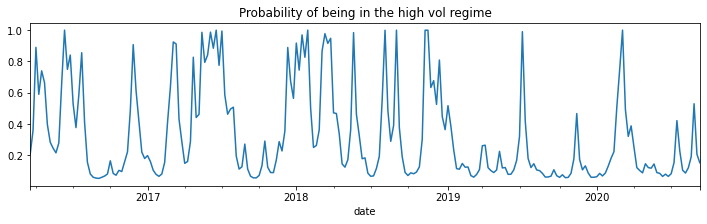

In [7]:
figure(figsize=(12,6))
plt.plot(df.close.values)

figure()
res_fedfunds.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in the low vol regime', figsize=(12,3));
figure()
res_fedfunds.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in the high vol regime', figsize=(12,3));

In [8]:
res_fedfunds.smoothed_marginal_probabilities
res_fedfunds.smoothed_marginal_probabilities['returns'] = df['returns']

mask_regime1 = (res_fedfunds.smoothed_marginal_probabilities[0] > .8)
mask_regime2 = (res_fedfunds.smoothed_marginal_probabilities[1] > .8)


regime1 = res_fedfunds.smoothed_marginal_probabilities.loc[mask_regime1]
regime2 = res_fedfunds.smoothed_marginal_probabilities.loc[mask_regime2]
print(regime1['returns'].mean(), regime1['returns'].std())
print(regime2['returns'].mean(), regime2['returns'].std())

0.020618493497655183 0.0743436653957257
-0.1398658712176154 0.347724793419055


we can see the second regime has higher average absolute returns as well as std (volatility), this is our high vovl regime.

However our AIC did not decrease, so our lagged return did not help the model any.

# Lets try a different input variable, trading range for each day (high-low) scaled by the closing price so the series is somewhat stationary

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                returns   No. Observations:                  236
Model:               MarkovRegression   Log Likelihood                 202.987
Date:                Sun, 20 Sep 2020   AIC                           -389.974
Time:                        22:34:49   BIC                           -362.263
Sample:                    03-14-2016   HQIC                          -378.803
                         - 09-14-2020                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0820      0.016      5.169      0.000       0.051       0.113
x1            -0.7366      0.050    -14.659      0.000      -0.835      -0.638
sigma2         0.0078      0.001      6.420      0.000       0.005       0.010
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0440      0.013     -3.472      0.001      -0.069      -0.019
x1             0.7201      0.048     15.024      0.000       0.626       0.814
sigma2         0.0030      0.001      5.550      0.000       0.002       0.004
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.5551      0.073      7.591      0.000       0.412       0.698
p[1->0]        0.4791      0.068      6.996      0.000       0.345       0.613
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

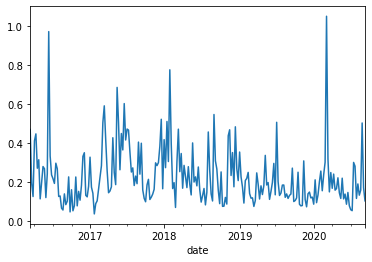

In [9]:
# # Fit the model
# # (a switching mean is the default of the MarkovRegession model)
df['range'] = (df['high'] - df['low'])/df['close'].abs()
df['range'].plot()

mod_fedfunds = sm.tsa.MarkovRegression(df.returns, k_regimes=2, switching_variance=True, exog=df.range)
res_fedfunds = mod_fedfunds.fit()
res_fedfunds.summary()

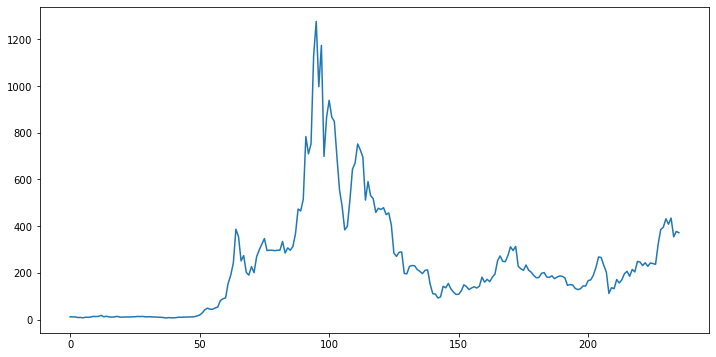

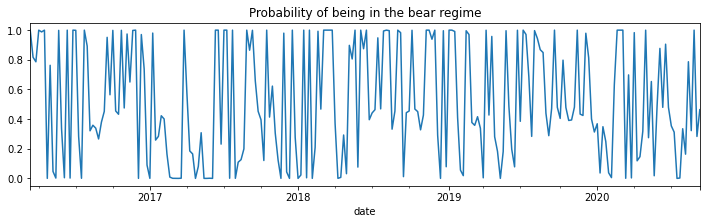

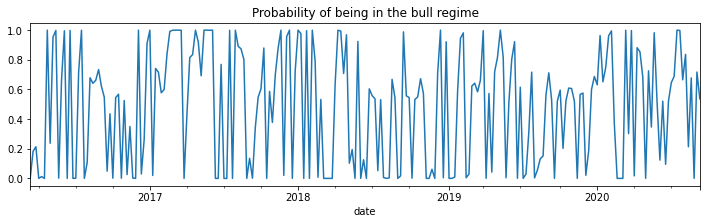

In [12]:
figure(figsize=(12,6))
plt.plot(df.close.values)

figure()
res_fedfunds.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in the bear regime', figsize=(12,3));
figure()
res_fedfunds.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in the bull regime', figsize=(12,3));

In [11]:
res_fedfunds.smoothed_marginal_probabilities
res_fedfunds.smoothed_marginal_probabilities['returns'] = df['returns']

mask_regime1 = (res_fedfunds.smoothed_marginal_probabilities[0] > .8)
mask_regime2 = (res_fedfunds.smoothed_marginal_probabilities[1] > .8)


regime1 = res_fedfunds.smoothed_marginal_probabilities.loc[mask_regime1]
regime2 = res_fedfunds.smoothed_marginal_probabilities.loc[mask_regime2]
print(regime1['returns'].mean(), regime1['returns'].std())
print(regime2['returns'].mean(), regime2['returns'].std())

-0.15499050124380467 0.15125028018073802
0.1779848701152345 0.08169651544520504


We had a large decrease in AIC which shows an improvement.  Now lets try both the previous inputs together.

In [24]:
# # Fit the model
# # (a switching mean is the default of the MarkovRegession model)
exog = pd.DataFrame(df['range'])
exog['signal'] = df['signal']


mod_fedfunds = sm.tsa.MarkovRegression(df.returns, k_regimes=2, switching_variance=True, exog=exog)
res_fedfunds = mod_fedfunds.fit()
res_fedfunds.summary()

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarn

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                returns   No. Observations:                  236
Model:               MarkovRegression   Log Likelihood                 523.766
Date:                Sun, 20 Sep 2020   AIC                          -1027.532
Time:                        22:47:23   BIC                           -992.894
Sample:                    03-14-2016   HQIC                         -1013.569
                         - 09-14-2020                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0086      0.006      1.385      0.166      -0.004       0.021
x1            -0.0607      0.041     -1.489      0.137      -0.141       0.019
x2             1.1505      0.051     22.497      0.000       1.050       1.251
sigma2         0.0011        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0130        nan        nan        nan         nan         nan
x1            -0.0261      0.009     -2.901      0.004      -0.044      -0.008
x2            -1.0294      0.011    -91.773      0.000      -1.051      -1.007
sigma2      8.254e-05        nan        nan        nan         nan         nan
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.5956      0.046     12.907      0.000       0.505       0.686
p[1->0]        0.5721      0.052     10.962      0.000       0.470       0.674
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

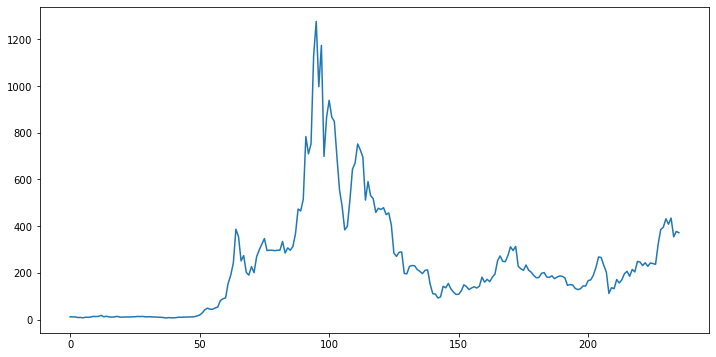

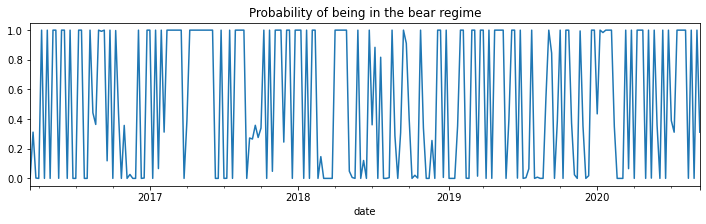

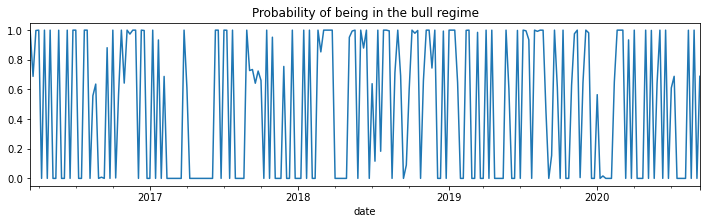

In [25]:
figure(figsize=(12,6))
plt.plot(df.close.values)

figure()
res_fedfunds.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in the bear regime', figsize=(12,3));
figure()
res_fedfunds.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in the bull regime', figsize=(12,3));

In [26]:
res_fedfunds.smoothed_marginal_probabilities
res_fedfunds.smoothed_marginal_probabilities['returns'] = df['returns']

mask_regime1 = (res_fedfunds.smoothed_marginal_probabilities[0] > .8)
mask_regime2 = (res_fedfunds.smoothed_marginal_probabilities[1] > .8)


regime1 = res_fedfunds.smoothed_marginal_probabilities.loc[mask_regime1]
regime2 = res_fedfunds.smoothed_marginal_probabilities.loc[mask_regime2]
print(regime1['returns'].mean(), regime1['returns'].std())
print(regime2['returns'].mean(), regime2['returns'].std())

0.12390522806456981 0.08822500300817282
-0.1474149435224799 0.14459924257599538


Our variables appear to do worse together than just the range input alone